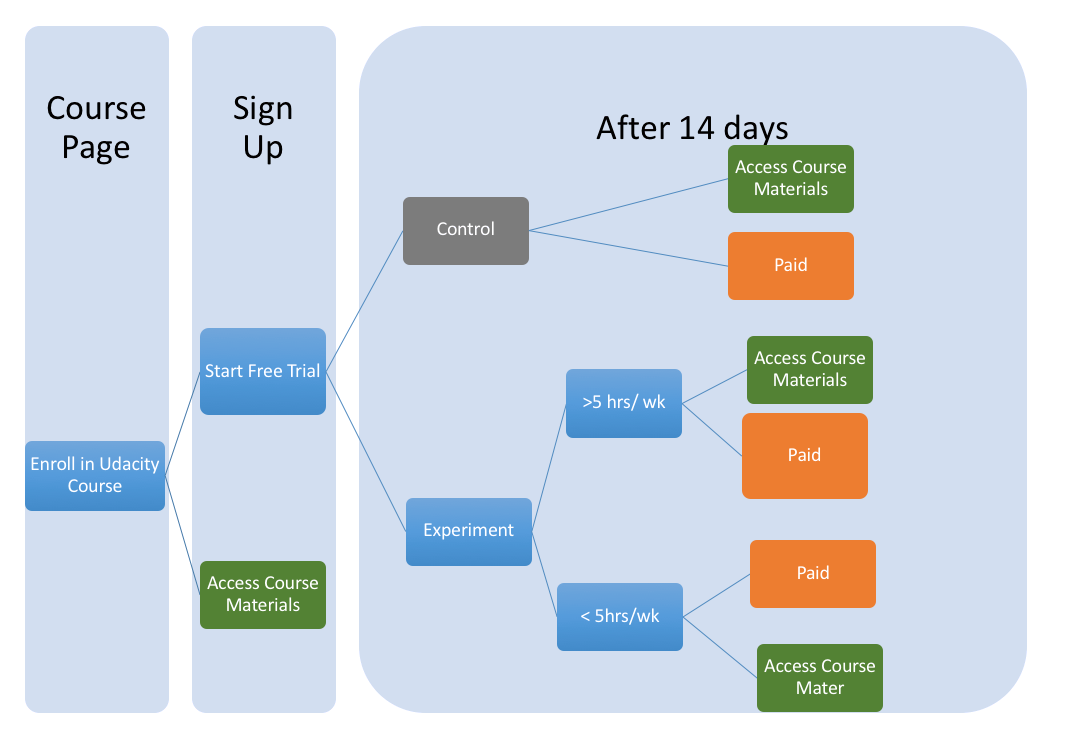

In [1]:
from IPython.display import Image
Image(filename='image.png')

# 1. ** Metrics Choices **

### **Invariant Metrics: ** number of cookies and number of clicks

> **Number of cookies:** is the number of unique cookies who view the course over page and is an invarient variable, because it can be used for both control and experiment groups. 

> **Number of clicks:** number of unique cookies click the "start free trial", is an invarient variable. It is similar to number of cookies but excludes users who choose "access to materials page", which we do not care for, and still is accountable for both control and experiment groups. 

> **Number of user-ids:** is number of unique cookies who enroll in "Start free trial", which means this is varient metric. Because if these users are only accountable for the control group but not the experiment group ( who have a choice to opt out if number of available hours is less than 5) 

>**Click-through-probability:** number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page, which is not a good  metric, because it is cookies/clicks - redundant 


### **Evaluation Metrics: ** retention and net conversion


>**Gross conversion:** number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button, which is not a good valuation metric, because this doesnt measure number of users who pay for the course, which is what we want to evaluate in our hypothesis


>**Retention:** number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout, which is a good evaluation metric, because it accounts for conversion rate based on total enrolled users, and include 14-day-trial users group. 

>**Net conversion:** number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button, which is also a good evaluation metric, because it justifies the conversion rate based on total users who wanted to try free trials, and include 14-day-trial users group. 

# 2. Measuring Variability

In [2]:
import pandas as pd
import numpy as np

In [3]:
xls = pd.ExcelFile('data.xlsx')
control = xls.parse('Control').fillna(0)
experiment = xls.parse('Experiment').fillna(0)

In [4]:
control.head(5)

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [5]:
experiment.head(5)

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


## a. Retention Rate

> Number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)

rtr = (startfreetrial + enrolled + make payment) / startfreetrial + enrolled

In [6]:
data = pd.read_csv('data.csv')
data

,Unique cookies to view page per day:,"Unique cookies to click ""Start free trial"" per day:",Enrollments per day:,"Click-through-probability on ""Start free trial"":","Probability of enrolling, given click:","Probability of payment, given enroll:","Probability of payment, given click"
0,40000,3200,660,0.08,0.20625,0.53,0.109313


In [7]:
baseline_retention_rate = 0.53
number_enrolled_freetrials =  660
std_retention = np.sqrt((baseline_retention_rate* (1-baseline_retention_rate))/number_enrolled_freetrials)
print('Standard deviation of retention rate is',round(std_retention,4))

Standard deviation of retention rate is 0.0194


## b. Net Conversion 

>Number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

nvr = (startfreetrial + enrolled + make payment) / startfreetrial

In [8]:
baseline_net_conversion = 0.109313
number_clicked_freetrials = 3200
std_net_conversion = np.sqrt((baseline_net_conversion * (1-baseline_net_conversion))/number_clicked_freetrials)
print('Standard deviation of retention rate is',round(std_net_conversion,4))

Standard deviation of retention rate is 0.0055


# 3. Sizing

We use [Calculator](http://www.evanmiller.org/ab-testing/sample-size.html) to calculate the optimal pageview size 

## a. Retention



Retention Baseline Conversion: 53%

Minimum Detectable Effect: 1%

alpha: 5%

beta: 20%

> Sample Size = 39 087 per variation 


> Total sample size = 39 087 x 2 = 78174 enrollments

Enrollments/Pageview Rate : 660/40000 = .0165 

Optimal Pageviews = 78174/.0165 = 4,737,818
 

# b. Net Conversion

Baseline Conversion: 10.9313%

Minimum Detectable Effect: .75%

alpha: 5%

beta: 20%

>Sample size = 27,413 per variation

>Total Sample Size = 27,413 x 2  = 54826

Clicks/Pageview Rate: 3200/40000 = .08 

Optimal Pageviews = 54826/0.08 = 685,325

# 4. Duration and Exposure

When determining the duration of the experiment, we want to reduce duration as much as possible without changing the user experience to too many users. First, we will consider duration necessary for evaluating retention and net conversion.

$$ Estimated\space Duration = \frac{Pageviews\space Required}{Daily\space Page\space Views * Exposure\space Proportion} $$

### Duration at 50% exposure 

In [9]:
retention_clicks = 4737818
conversion_clicks = 685325
daily_page_views = 40000
exposure = 0.5
retention_duration = retention_clicks/(daily_page_views*exposure)
conversion_duration = conversion_clicks/(daily_page_views*exposure)
print("Duration required to evaluate retention:", retention_duration, "days")
print("Duration required to evaluate net conversion:", conversion_duration, "days")

Duration required to evaluate retention: 236.8909 days
Duration required to evaluate net conversion: 34.26625 days


The time required to evaluate retention will take several months. Thus, we will **drop retention** as an evaluation metric and **continue with net conversion**.

### Duration at 80% Exposure

In [10]:
exposure = 0.8
duration = conversion_clicks/(daily_page_views*exposure)
print(duration, "days")

21.41640625 days


We decided to allow **80%** of traffic to be directed to the experiment to allow the time frame to be within **3 weeks**. 
This involves a **risk of 40% of users** from the experimental group viewing the unevaluated version of the website. 

Potentially, more users in this experimental time-frame will be discouraged from starting the free trial, but we believe this risk is worthwhile to be able to conduct the experiment while keeping it as short as possible. It is still less of a risk than directing all of the traffic to our experiment, however, we can direct all traffic if we observe that the experimental change results in increased conversion rate.



# 5. Sanity Check:

Invariant metrics:  
- Number of Pageviews  
- Number of Clicks  


In [24]:
results = {"Control":pd.Series([control.Pageviews.sum(),control.Clicks.sum()],  
                               index = ["cookies","clicks"]), 
           "Experiment":pd.Series([experiment.Pageviews.sum(),experiment.Clicks.sum()], 
                                  index = ["cookies","clicks"])} 
df_results = pd.DataFrame(results)

In [25]:
df_results['Total']=df_results.Control + df_results.Experiment
#df_results['Prob'] = df_results.Control/df_results.Total
df_results['Prob'] = 0.5
df_results['StdErr'] = np.sqrt((df_results.Prob * (1- df_results.Prob))/df_results.Total)
df_results["MargErr"] = 1.96 * df_results.StdErr
df_results["CI_lower"] = df_results.Prob - df_results.MargErr
df_results["CI_upper"] = df_results.Prob + df_results.MargErr
df_results["Obs_val"] = df_results.Experiment/df_results.Total
df_results["Pass_Sanity"] = df_results.apply(lambda x: (x.Obs_val > x.CI_lower) and (x.Obs_val < x.CI_upper),axis=1)
df_results['Diff'] = abs((df_results.Experiment - df_results.Control)/df_results.Total)

df_results

,Control,Experiment,Total,Prob,StdErr,MargErr,CI_lower,CI_upper,Obs_val,Pass_Sanity,Diff
cookies,345543,344660,690203,0.5,0.000602,0.001180,0.498820,0.501180,0.499360,True,0.001279
clicks,28378,28325,56703,0.5,0.002100,0.004116,0.495884,0.504116,0.499533,True,0.000935


# 6. Check for Practical and Statistical Significance

Evaluation Metrics:
- Net Conversion Rate


In [15]:
Net_Conversion_exp = sum(experiment.Payments)/sum(experiment.Clicks)
Net_Conversion_cont = sum(control.Payments)/sum(control.Clicks)
N_exp = sum(experiment.Clicks)
N_cont = sum(control.Clicks)

In [26]:
def stats(p_cont, p_exp, N_cont, N_exp):
    z_score = 1.96
    se1 = np.sqrt((p_cont*(1-p_cont))/N_cont)
    se2 = np.sqrt((p_exp*(1-p_exp))/N_exp)
    se_diff = np.sqrt(se1**2 + se2**2)
    diff = se1-se2
    marg_err = z_score * se_diff
    ci_lower = diff - marg_err
    ci_upper = diff + marg_err
    return (ci_lower,ci_upper)

In [27]:
Net_Conversion_CI = stats(Net_Conversion_cont,Net_Conversion_exp, N_cont, N_exp)

In [28]:
Net_Conversion_CI

(-0.004176088317170693, 0.0042326836314998803)

>#### Net Conversion Interval includes 0
>#### The upper bound of the CI < dmin= 0.0075
### There is not enough to conclude that Treatment is effective

# 7. Sign Test

In [20]:
df_SignTest = pd.merge(control,experiment,on="Date")

df_SignTest['NetConversion_cont'] = df_SignTest.Payments_x/df_SignTest.Clicks_x
df_SignTest['NetConversion_exp'] = df_SignTest.Payments_y/df_SignTest.Clicks_y

cols = ['Date','NetConversion_cont','NetConversion_exp']
df_SignTest = df_SignTest[cols]

df_SignTest['NC_Sign'] = df_SignTest.NetConversion_exp - df_SignTest.NetConversion_cont

In [23]:
df_SignTest.head(5)

,Date,NetConversion_cont,NetConversion_exp,NC_Sign
0,"Sat, Oct 11",0.101892,0.049563,-0.052330
1,"Sun, Oct 12",0.089859,0.115924,0.026065
2,"Mon, Oct 13",0.104510,0.089367,-0.015144
3,"Tue, Oct 14",0.125598,0.111245,-0.014353
4,"Wed, Oct 15",0.076464,0.112981,0.036517


[SignTest Calculator](http://graphpad.com/quickcalcs/binomial1.cfm)

In [22]:
pass_sign_test = len(df_SignTest[df_SignTest.NC_Sign > 0.0075])
total = len(df_SignTest)
print ("The number of passes = ", pass_sign_test)
print ("The total number of records = ", total)
print("The p value for the net conversion rate sign test is 0.21") 

The number of passes =  8
The total number of records =  37
The p value for the net conversion rate sign test is 0.21


**The p-value of 0.21 is greater than the level of significance (0.05) for the sign test, so net conversion rate is not statistically significantly different between the groups.**

# 8. Recommendation

Net convserion rate failed the sign test, and its confidence interval includes 0 therefore there is not enough evidence to conclude that the experimental group is statistically significantly different. 

Therefore, feature does not accomplish our goal of setting clearer expectations for students upfront, and reducing the number of frustrated students who left the free trial because they didn't have enough time.

Using net conversion rate as our evaluation metric, we **do not recommend** implementing this new website feature. 

# 9. Follow-Up Experiment: How to Reduce Early Cancellations¶


To reduce early cancellations we would conduct an AB test on different approaches of coaching support. 

In the control group, the coach will continue to be a passive support available to the student upon request.

In the experimental group, the coach will be more proactive, performing frequently checks on the student to consistently provide adequate support. We hypothesize that the experimental group will be more motivated and accountable for completing the course and will result in less early cancellations.

Similar to the previous experiment, would use number of cookies and number of clicks as invariant metrics as we expect these measures not to be different between the groups. We select Retention as our evaluation metric, because we want to measure the number of users who complete the first payment divided by the number of users enrolled.